<a href="https://colab.research.google.com/github/Pavansabavat/NLP-/blob/main/NLP_%F0%9F%93%9D_GloVe%2C_BERT%2C_TF_IDF%2C_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns

In [4]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)



from keras.utils  import pad_sequences


In [7]:
df=pd.read_csv('/content/spam.csv',encoding="latin-1")

In [8]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
df=df.dropna(how='any',axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: >

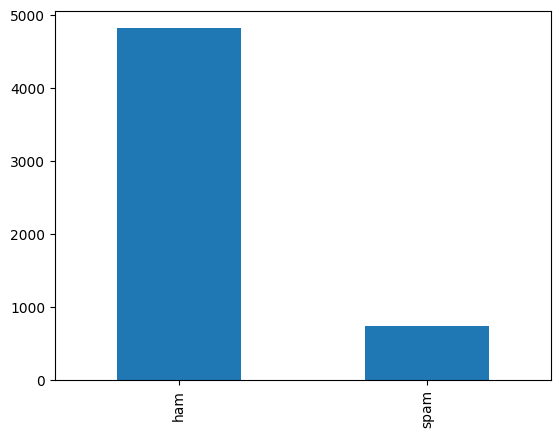

In [11]:
df['v1'].value_counts().plot(kind='bar')

In [12]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [15]:
df.columns=['target','message']
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
df['message_len']=df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [31]:
df['message'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [30]:
df['message_len'].max()

171

In [32]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

In [36]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

<Axes: ylabel='Density'>

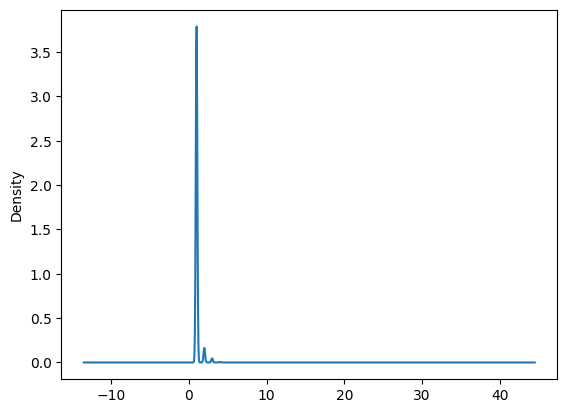

In [42]:
df['message'].value_counts().plot(kind='kde')

In [44]:
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

###**Data Preprocessing**


In [45]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [46]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


In [48]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [49]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


In [51]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [52]:
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


In [53]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))

    return text

In [54]:
df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


In [55]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


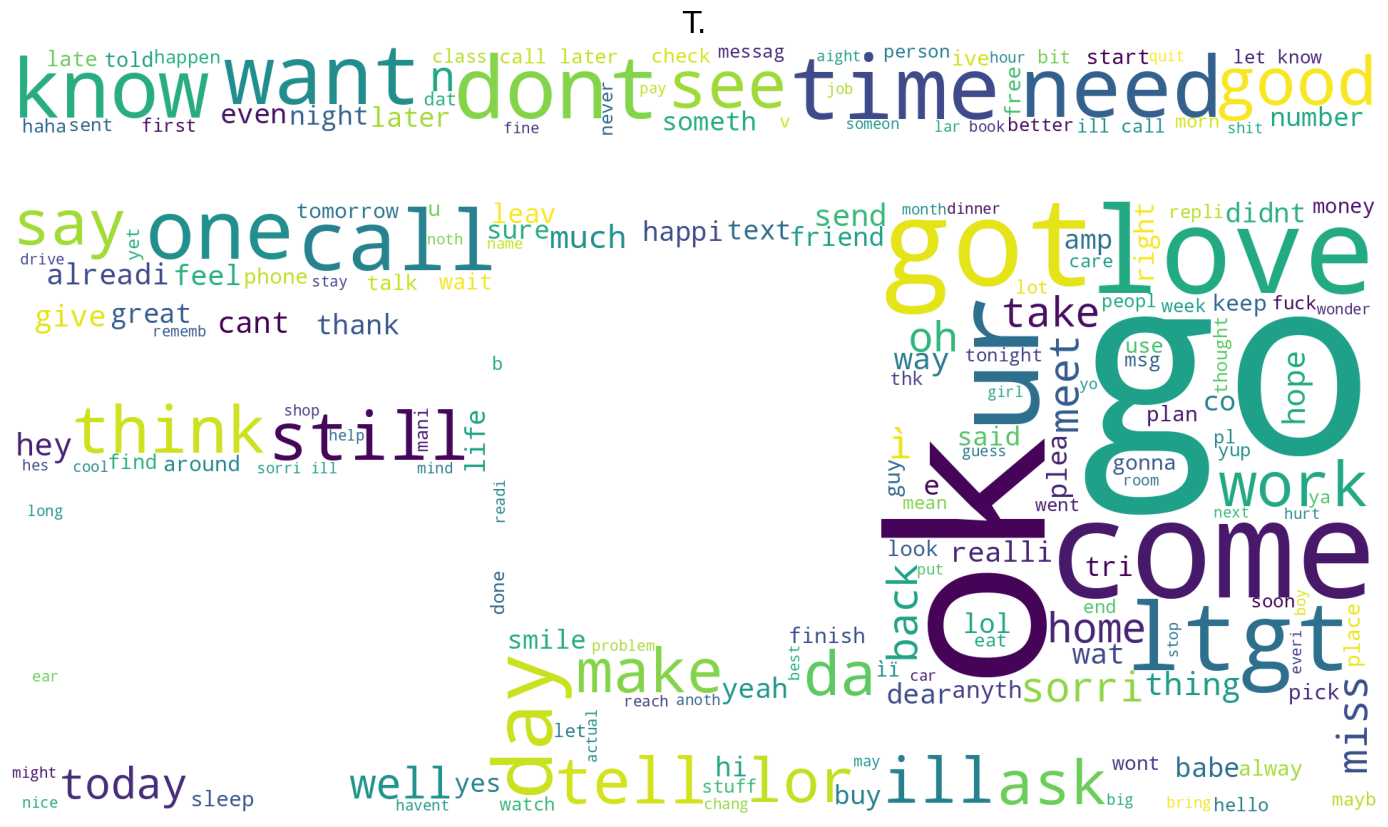

In [65]:
twitter_mask = np.array(Image.open('/content/Screenshot (2).png'))

wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [63]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

5572 5572


In [66]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))


4179 4179
1393 1393


In [67]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [68]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [69]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [70]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4179x5683 sparse matrix of type '<class 'numpy.float64'>'
	with 32201 stored elements in Compressed Sparse Row format>


Thanks to: https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm

In [71]:
texts = df['message_clean']
target = df['target_encoded']

In [72]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6724

Pad_sequences

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/*pad_sequences*

In [86]:
import tensorflow  as tf

In [90]:
# from keras. import pad_sequences
# X_test = pad_sequences(X_test, maxlen=500)
# keras.utils.pad_sequences(
#     sequences, maxlen=None, dtype='int32', padding='pre',
#     truncating='pre', value=0.0
# )

# # from keras.preprocessing.sequence import pad_sequences

In [88]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [89]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[   2, 3179,  274, ...,    0,    0,    0],
       [   8,  236,  527, ...,    0,    0,    0],
       [   9,  356,  588, ...,    0,    0,    0],
       ...,
       [6722, 1002, 6723, ...,    0,    0,    0],
       [ 138, 1251, 1604, ...,    0,    0,    0],
       [1986,  378,  170, ...,    0,    0,    0]], dtype=int32)

In [93]:
# embeddings_dictionary = dict()
# embedding_dim = 100

# # Load GloVe 100D embeddings
# with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as fp:
#     for line in fp.readlines():
#         records = line.split()
#         word = records[0]
#         vector_dimensions = np.asarray(records[1:], dtype='float32')
#         embeddings_dictionary [word] = vector_dimensions

# # embeddings_dictionary

In [94]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [95]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [96]:
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [100]:
# calculate accuracy of class predictions
from sklearn import metrics
from sklearn.metrics import confusion_matrix

print(metrics.accuracy_score(y_test, y_pred_class))

(metrics.confusion_matrix(y_test, y_pred_class))

0.9784637473079684


array([[1191,   11],
       [  19,  172]])

In [101]:
metrics.roc_auc_score(y_test, y_pred_prob)


0.974296765425861

In [102]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()),
                 ('tfid', TfidfTransformer()),
                 ('model', MultinomialNB())])

In [107]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

# confusion_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9597989949748744


In [109]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

In [111]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

# conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

Train: 0.9837281646326872
Test: 0.9662598707824839


In [112]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

In [113]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data

def glove_lstm():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 100)           672400    
                                                                 
 bidirectional (Bidirectiona  (None, 80, 160)          115840    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 160)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                        

In [114]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    X_train,
    y_train,
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
131/131 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.8658
Epoch 1: val_loss improved from inf to 0.64497, saving model to model.h5
131/131 [==============================] - 55s 354ms/step - loss: 0.6673 - accuracy: 0.8658 - val_loss: 0.6450 - val_accuracy: 0.8665 - lr: 0.0010
Epoch 2/7
131/131 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.8658
Epoch 2: val_loss improved from 0.64497 to 0.60440, saving model to model.h5
131/131 [==============================] - 43s 331ms/step - loss: 0.6245 - accuracy: 0.8658 - val_loss: 0.6044 - val_accuracy: 0.8665 - lr: 0.0010
Epoch 3/7
131/131 [==============================] - ETA: 0s - loss: 0.5866 - accuracy: 0.8658
Epoch 3: val_loss improved from 0.60440 to 0.56850, saving model to model.h5
131/131 [==============================] - 42s 321ms/step - loss: 0.5866 - accuracy: 0.8658 - val_loss: 0.5685 - val_accuracy: 0.8665 - lr: 0.0010
Epoch 4/7
131/131 [============================

In [118]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

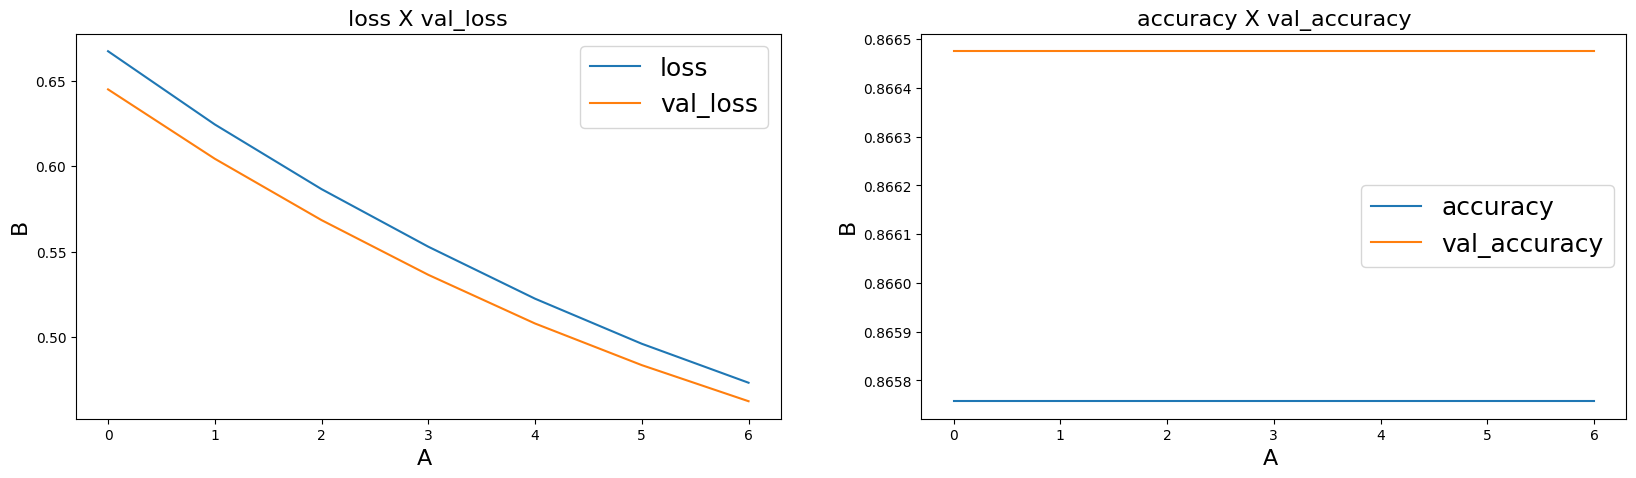

In [119]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [120]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")

44/44 [==============================] - 2s 41ms/step


In [121]:
# install transformers
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.3 MB/s eta 0:00:00


In [122]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [123]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

except:
    strategy = tf.distribute.get_strategy()

print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [124]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [125]:
texts = df['message_clean']
target = df['target_encoded']

train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [126]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):

    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [127]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [128]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [130]:
##   takes  more time  to run   this  code
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2,
    epochs=3,
    batch_size=10
)

Epoch 1/3
446/446 [==============================] - 4165s 9s/step - loss: 0.4469 - accuracy: 0.8582 - val_loss: 0.3877 - val_accuracy: 0.8700
Epoch 2/3
446/446 [==============================] - 4179s 9s/step - loss: 0.4244 - accuracy: 0.8649 - val_loss: 0.3868 - val_accuracy: 0.8700
Epoch 3/3
446/446 [==============================] - 4203s 9s/step - loss: 0.4143 - accuracy: 0.8649 - val_loss: 0.3891 - val_accuracy: 0.8700


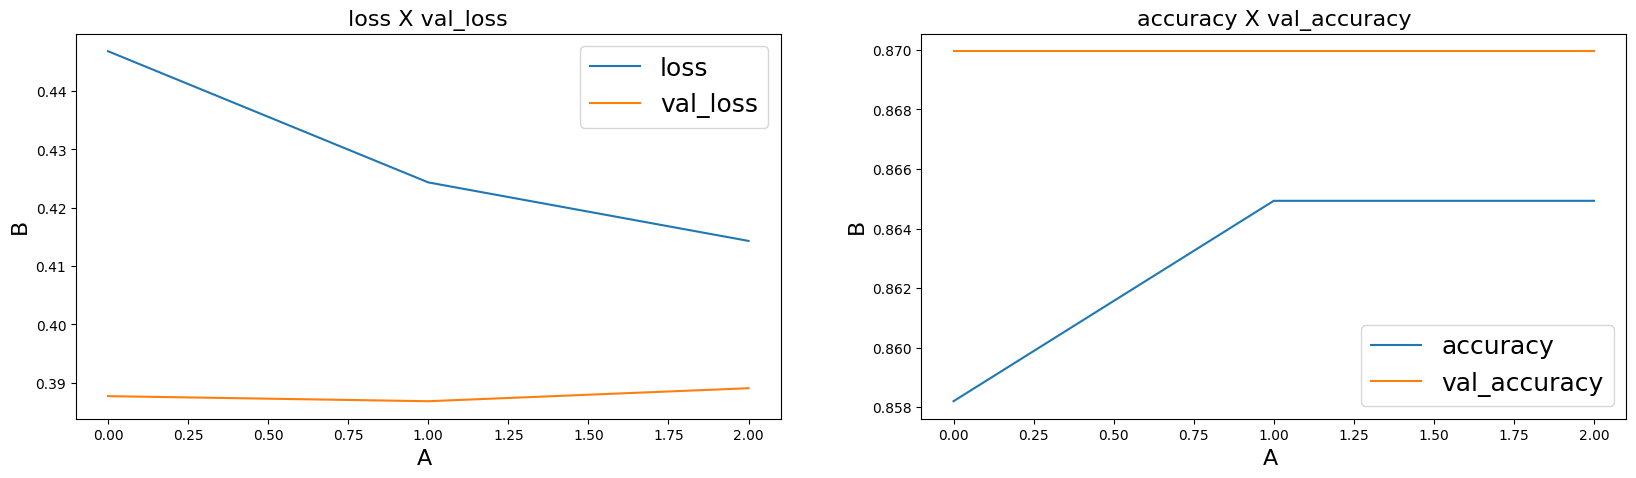

In [131]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])